# Pneumo Vision

This is a computer vision machine learning model to classify chest xray images as having pneumomnia or not. 

> **Note:** this is not a novel problem or solution to the problem. I wrote this notebook as a means of exercising HuggingFace and PyTorch knowledge in the computer vision space, and I am by no means a xray imaging expert or am being paid to develop this code. Please use it with your own discretion.

## Model Architecture

The model uses a Vision Transformer (ViT) architecture; actually it uses the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) pre-trained open source model (Apache 2.0 license) which is a ViT model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at 224x224 resolution. 

Next, the model is fine-tuned on a sample dataset [keremberke/chest-xray-classification](https://huggingface.co/datasets/keremberke/chest-xray-classification) which contains 4077 training, 582 test, and 1165 validation images.

In [23]:
import torch
import torchvision.transforms as transforms

print(torch.__version__)

# Setup device agnostic code
device = 'gpu' if torch.cuda.is_available() else 'cpu'

2.2.2


## 1. Load Data

In [24]:
# Load dataset from huggingface
from datasets import load_dataset

dataset = load_dataset("keremberke/chest-xray-classification", name='full')

In [25]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})

In [26]:
dataset["train"].features

{'image_file_path': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['NORMAL', 'PNEUMONIA'], id=None)}

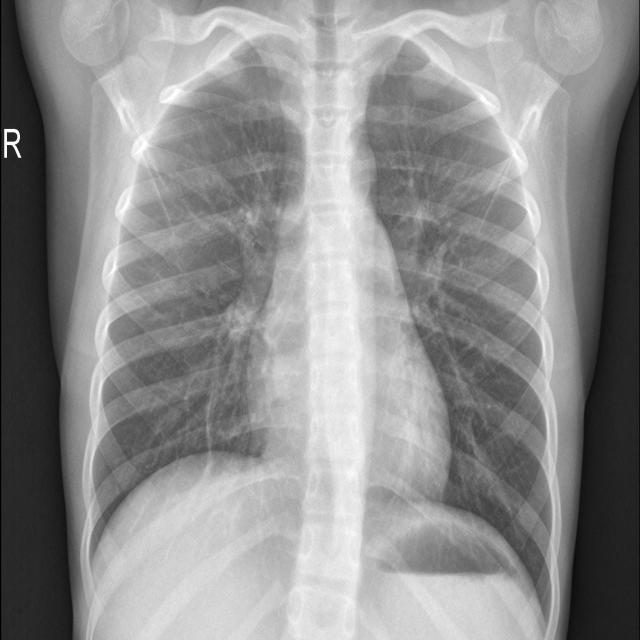

In [27]:
example_img = dataset["train"][0]["image"]

example_img

In [6]:
labels = dataset["train"].features["labels"].names
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

id2label

{0: 'NORMAL', 1: 'PNEUMONIA'}

## 2. Pre-Processing Data

We will pre-process the data with the following sequence of transformations:  

1. `RandomResizeCrop(size)` - Crop a random portion of image and resize it to a given size
2. `ToTensor()` - Convert the PIL image to a tensor to play well with PyTorch
3. `Normalize(mean, std)` - Normalize the tensor image with mean and standard deviation

In [7]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

size = image_processor.size['height']
print(size)
print(image_processor.image_mean)
print(image_processor.image_std)

224
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]


In [10]:
normalize = transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# Sequence of transformations to apply to the images
_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size),
    transforms.ToTensor(),
    normalize,
])


def preprocess(examples):    
    """
    Preprocess the examples by applying the transformations to the images
    and storing in the pixel_values column. image column is removed.

    :param examples: torch dataset to be preprocessed
    :return: preprocessed examples with pixel_values column added and image column removed
    """
    examples['pixel_values'] = [_transforms(image.convert("RGB")) for image in examples['image']]
    del examples['image']
    return examples


In [11]:
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)

In [16]:
train_ds[:1]["pixel_values"][0].shape


torch.Size([3, 224, 224])

## 3. Setup Model

In [17]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
from transformers import AutoModelForImageClassification, TrainingArguments

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from pathlib import Path

output_dir = Path('results') / Path('vit-pneumo-vision-small')

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy='epoch',
    remove_unused_columns=False,
    num_train_epochs=10,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    fp16=device == 'gpu',
    save_strategy='epoch',
    save_total_limit=3,
)

## 4. Training

In [21]:
from transformers import Trainer, EarlyStoppingCallback, DefaultDataCollator

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DefaultDataCollator(),
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

In [20]:
trainer.train()

                                                
 20%|██        | 63/315 [03:35<12:49,  3.05s/it]

{'eval_loss': 0.509010910987854, 'eval_accuracy': 0.7605150214592274, 'eval_runtime': 19.5659, 'eval_samples_per_second': 59.542, 'eval_steps_per_second': 3.731, 'epoch': 0.99}


                                                 
 40%|████      | 127/315 [07:14<09:41,  3.10s/it]

{'eval_loss': 0.35247132182121277, 'eval_accuracy': 0.8472103004291845, 'eval_runtime': 19.21, 'eval_samples_per_second': 60.645, 'eval_steps_per_second': 3.8, 'epoch': 1.99}


                                                 
 61%|██████    | 191/315 [10:52<06:19,  3.06s/it]

{'eval_loss': 0.31527528166770935, 'eval_accuracy': 0.8592274678111588, 'eval_runtime': 19.1168, 'eval_samples_per_second': 60.941, 'eval_steps_per_second': 3.819, 'epoch': 3.0}


                                                 
 81%|████████  | 255/315 [14:28<03:00,  3.01s/it]

{'eval_loss': 0.26340243220329285, 'eval_accuracy': 0.8875536480686695, 'eval_runtime': 18.9201, 'eval_samples_per_second': 61.575, 'eval_steps_per_second': 3.858, 'epoch': 4.0}


                                                 
100%|██████████| 315/315 [17:54<00:00,  3.13s/it]

{'eval_loss': 0.2519606053829193, 'eval_accuracy': 0.8927038626609443, 'eval_runtime': 19.2065, 'eval_samples_per_second': 60.657, 'eval_steps_per_second': 3.801, 'epoch': 4.94}


100%|██████████| 315/315 [17:57<00:00,  3.42s/it]

{'train_runtime': 1077.4292, 'train_samples_per_second': 18.92, 'train_steps_per_second': 0.292, 'train_loss': 0.35738888695126486, 'epoch': 4.94}


TrainOutput(global_step=315, training_loss=0.35738888695126486, metrics={'train_runtime': 1077.4292, 'train_samples_per_second': 18.92, 'train_steps_per_second': 0.292, 'total_flos': 1.5613086067547996e+18, 'train_loss': 0.35738888695126486, 'epoch': 4.9411764705882355})

## 5. Evaluation

In [21]:
results = trainer.evaluate()
print(results)

trainer.save_model(output_dir)


100%|██████████| 73/73 [00:18<00:00,  3.89it/s]


{'eval_loss': 0.23565071821212769, 'eval_accuracy': 0.896137339055794, 'eval_runtime': 19.1223, 'eval_samples_per_second': 60.924, 'eval_steps_per_second': 3.818, 'epoch': 4.9411764705882355}


In [22]:
trainer.evaluate(train_ds)

100%|██████████| 255/255 [01:08<00:00,  3.71it/s]


{'eval_loss': 0.25973206758499146,
 'eval_accuracy': 0.8920775079715477,
 'eval_runtime': 69.1794,
 'eval_samples_per_second': 58.934,
 'eval_steps_per_second': 3.686,
 'epoch': 4.9411764705882355}

In [23]:
trainer.evaluate(test_ds)


100%|██████████| 37/37 [00:09<00:00,  3.81it/s]


{'eval_loss': 0.265353262424469,
 'eval_accuracy': 0.8848797250859106,
 'eval_runtime': 10.0786,
 'eval_samples_per_second': 57.746,
 'eval_steps_per_second': 3.671,
 'epoch': 4.9411764705882355}

In [24]:
trainer.evaluate(val_ds)


100%|██████████| 73/73 [00:18<00:00,  3.85it/s]


{'eval_loss': 0.23365063965320587,
 'eval_accuracy': 0.9072961373390558,
 'eval_runtime': 19.2646,
 'eval_samples_per_second': 60.474,
 'eval_steps_per_second': 3.789,
 'epoch': 4.9411764705882355}

## 6. Inference

PNEUMONIA


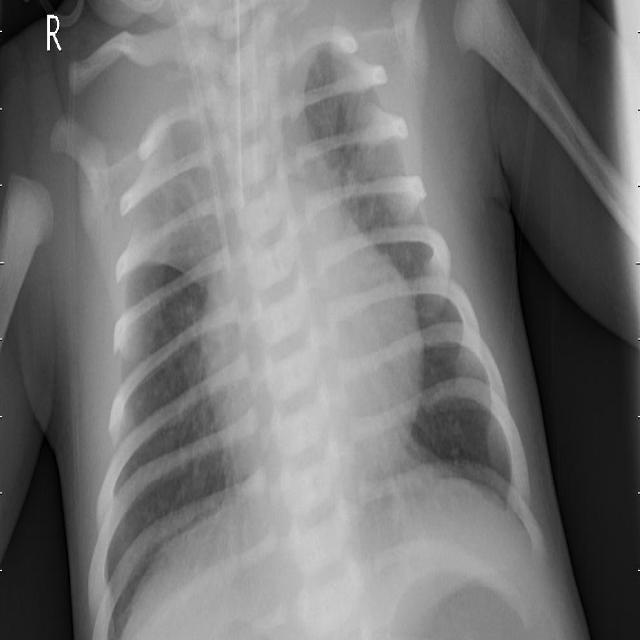

In [30]:
mini_dataset = load_dataset("keremberke/chest-xray-classification", name='mini')

test_img, test_label = mini_dataset["train"][-1]["image"], id2label[mini_dataset["train"][-1]["labels"]]
print(test_label)
test_img

In [31]:
from transformers import pipeline

classifier = pipeline("image-classification", model=output_dir)
classifier(test_img)

[{'label': 'PNEUMONIA', 'score': 0.9768173098564148},
 {'label': 'NORMAL', 'score': 0.023182719945907593}]